In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from collections import Counter
import re
from difflib import SequenceMatcher

# Set style
plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette("husl")

# Load data
train_df = pd.read_csv('grammar_train.csv')
valid_df = pd.read_csv('grammar_valid.csv')

# Combine datasets
train_df['split'] = 'train'
valid_df['split'] = 'valid'
df = pd.concat([train_df, valid_df], ignore_index=True)

print("="*70)
print("GRAMMAR DATA DESCRIPTIVE ANALYSIS")
print("="*70)
print(f"\nTotal samples: {len(df):,}")
print(f"Training samples: {len(train_df):,} ({len(train_df)/len(df)*100:.1f}%)")
print(f"Validation samples: {len(valid_df):,} ({len(valid_df)/len(df)*100:.1f}%)")
print("="*70)

GRAMMAR DATA DESCRIPTIVE ANALYSIS

Total samples: 271,625
Training samples: 244,462 (90.0%)
Validation samples: 27,163 (10.0%)



SECTION 1: SENTENCE LENGTH ANALYSIS

Descriptive Statistics:
       source_length  target_length  length_diff
count      271625.00      271625.00    271625.00
mean           16.22          16.77         0.56
std            13.82          13.73         1.33
min             1.00           1.00       -17.00
25%            10.00          10.00         0.00
50%            13.00          14.00         0.00
75%            17.00          18.00         1.00
max           220.00         222.00        24.00

Length Change Patterns:
  Sentences got longer: 133,021 (49.0%)
  Sentences got shorter: 49,348 (18.2%)
  No length change: 89,256 (32.9%)

✓ Saved: 1a_source_length.png


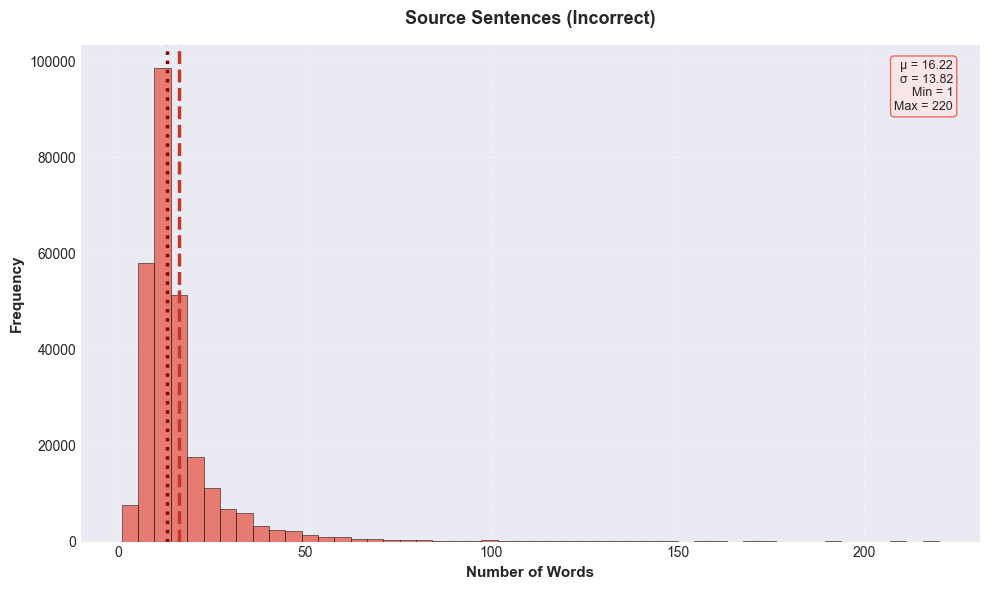


✓ Saved: 1b_target_length.png


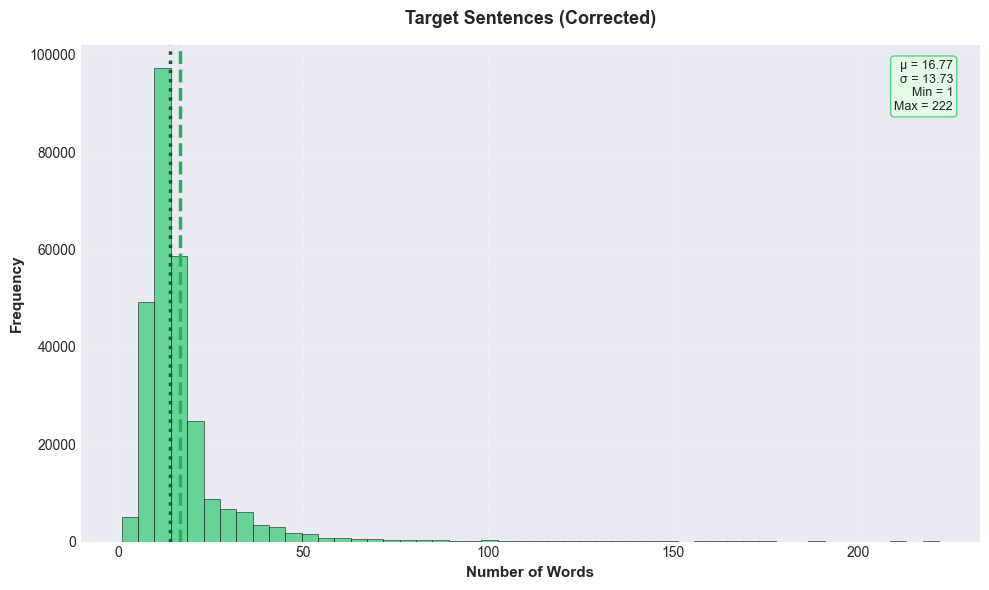

In [14]:
# Calculate sentence lengths
df['source_length'] = df['source'].str.split().str.len()
df['target_length'] = df['target'].str.split().str.len()
df['length_diff'] = df['target_length'] - df['source_length']

print("\n" + "="*70)
print("SECTION 1: SENTENCE LENGTH ANALYSIS")
print("="*70)

# Statistics
print("\nDescriptive Statistics:")
print(df[['source_length', 'target_length', 'length_diff']].describe().round(2))

print("\nLength Change Patterns:")
print(f"  Sentences got longer: {(df['length_diff'] > 0).sum():,} ({(df['length_diff'] > 0).sum()/len(df)*100:.1f}%)")
print(f"  Sentences got shorter: {(df['length_diff'] < 0).sum():,} ({(df['length_diff'] < 0).sum()/len(df)*100:.1f}%)")
print(f"  No length change: {(df['length_diff'] == 0).sum():,} ({(df['length_diff'] == 0).sum()/len(df)*100:.1f}%)")

# Figure 1: Source Sentences
fig, ax = plt.subplots(figsize=(10, 6))

ax.hist(df['source_length'], bins=50, alpha=0.7, color='#e74c3c', 
        edgecolor='black', linewidth=0.5)
ax.axvline(df['source_length'].mean(), color='#c0392b', linestyle='--', 
           linewidth=2.5, label=f'Mean: {df["source_length"].mean():.1f}')
ax.axvline(df['source_length'].median(), color='#8b0000', linestyle=':', 
           linewidth=2.5, label=f'Median: {df["source_length"].median():.1f}')
ax.set_title('Source Sentences (Incorrect)', fontsize=13, fontweight='bold', pad=15)
ax.set_xlabel('Number of Words', fontsize=11, fontweight='bold')
ax.set_ylabel('Frequency', fontsize=11, fontweight='bold')
ax.grid(alpha=0.3, linestyle='--')

# Add statistics annotation
source_stats = (
    f'μ = {df["source_length"].mean():.2f}\n'
    f'σ = {df["source_length"].std():.2f}\n'
    f'Min = {df["source_length"].min():.0f}\n'
    f'Max = {df["source_length"].max():.0f}'
)
ax.text(0.97, 0.97, source_stats, transform=ax.transAxes,
        fontsize=9, verticalalignment='top', horizontalalignment='right',
        bbox=dict(boxstyle='round', facecolor='#ffe6e6', alpha=0.8, edgecolor='#e74c3c'))

plt.tight_layout()
plt.savefig('1a_source_length.png', dpi=300, bbox_inches='tight')
print("\n✓ Saved: 1a_source_length.png")
plt.show()


# Figure 2: Target Sentences
fig, ax = plt.subplots(figsize=(10, 6))

ax.hist(df['target_length'], bins=50, alpha=0.7, color='#2ecc71', 
        edgecolor='black', linewidth=0.5)
ax.axvline(df['target_length'].mean(), color='#27ae60', linestyle='--', 
           linewidth=2.5, label=f'Mean: {df["target_length"].mean():.1f}')
ax.axvline(df['target_length'].median(), color='#145a32', linestyle=':', 
           linewidth=2.5, label=f'Median: {df["target_length"].median():.1f}')
ax.set_title('Target Sentences (Corrected)', fontsize=13, fontweight='bold', pad=15)
ax.set_xlabel('Number of Words', fontsize=11, fontweight='bold')
ax.set_ylabel('Frequency', fontsize=11, fontweight='bold')
ax.grid(alpha=0.3, linestyle='--')

# Add statistics annotation
target_stats = (
    f'μ = {df["target_length"].mean():.2f}\n'
    f'σ = {df["target_length"].std():.2f}\n'
    f'Min = {df["target_length"].min():.0f}\n'
    f'Max = {df["target_length"].max():.0f}'
)
ax.text(0.97, 0.97, target_stats, transform=ax.transAxes,
        fontsize=9, verticalalignment='top', horizontalalignment='right',
        bbox=dict(boxstyle='round', facecolor='#e6ffe6', alpha=0.8, edgecolor='#2ecc71'))

plt.tight_layout()
plt.savefig('1b_target_length.png', dpi=300, bbox_inches='tight')
print("\n✓ Saved: 1b_target_length.png")
plt.show()


SECTION 4: ERROR PATTERN DETECTION

Detected Error Patterns:
  Article Error                  : 91,257 (33.6%)
  Preposition Error              : 55,282 (20.4%)
  Spelling                       : 21,203 (7.8%)
  Subject Verb Agreement         : 13,530 (5.0%)
  Plural Error                   :  5,199 (1.9%)
  Word Order                     :  4,747 (1.7%)
  Tense Error                    :  3,143 (1.2%)

Total patterns detected: 194,361
Average patterns per sentence: 0.72

Note: Each sentence is counted only once for its primary error type.

✓ Saved: 4_error_patterns.png


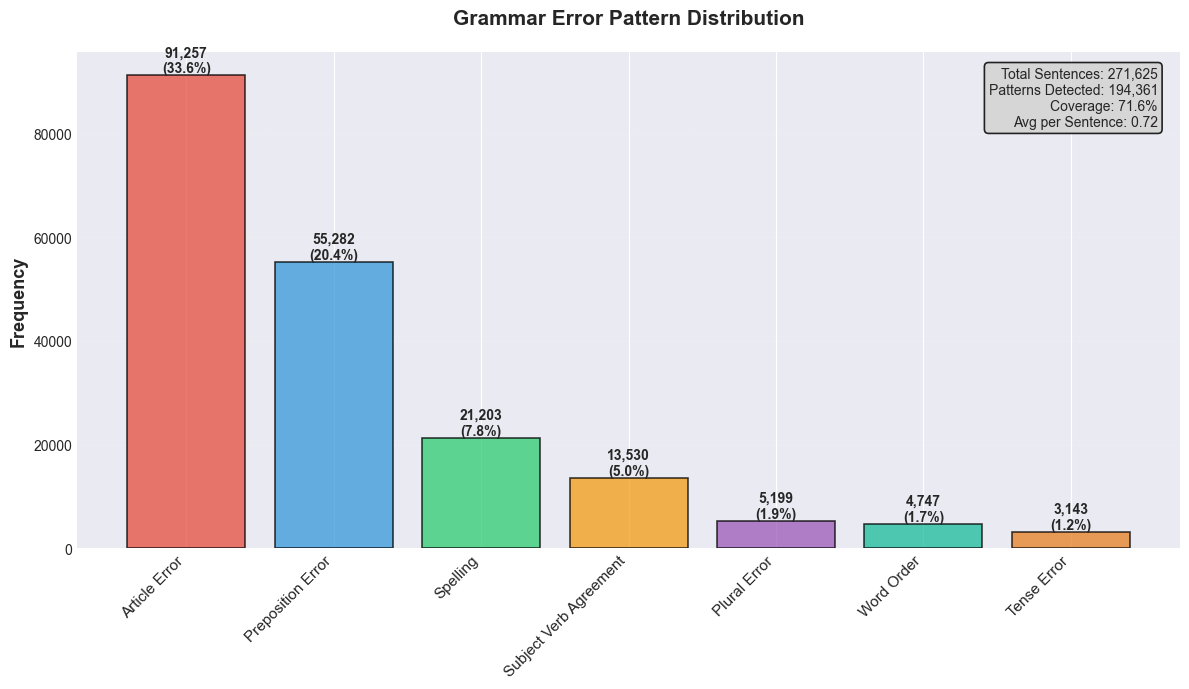

In [17]:
def detect_error_patterns(df):
    """Detect specific grammar error patterns"""
    patterns = {
        'subject_verb_agreement': 0,
        'article_error': 0,
        'preposition_error': 0,
        'tense_error': 0,
        'plural_error': 0,
        'spelling': 0,
        'word_order': 0
    }
    
    for _, row in df.iterrows():
        source = str(row['source']).lower()
        target = str(row['target']).lower()
        source_words = source.split()
        target_words = target.split()
        
        # 1. Subject-verb agreement - ✅ Good
        sv_patterns = [
            'i is', 'i was', 'i were', 'he have', 'she have', 'it have',
            'they was', 'we was', 'you was', 'he go', 'she go', 'it go',
            'they is', 'we is', 'he do', 'she do', 'it do'
        ]
        if any(pattern in source for pattern in sv_patterns):
            patterns['subject_verb_agreement'] += 1
            continue
        
        # 2. Article errors - 🔧 Improved
        article_changed = False
        
        # a <-> an swap
        if ('a ' in source and 'an ' in target) or ('an ' in source and 'a ' in target):
            article_changed = True
        
        # Article addition/deletion
        source_articles = len(re.findall(r'\b(a|an|the)\b', source))
        target_articles = len(re.findall(r'\b(a|an|the)\b', target))
        if abs(source_articles - target_articles) >= 1:  # More flexible
            article_changed = True
        
        if article_changed:
            patterns['article_error'] += 1
            continue
        
        # 3. Preposition errors - 🔧 Improved (removed strict length requirement)
        prepositions = ['in', 'on', 'at', 'for', 'to', 'with', 'from', 'by', 'of', 'about', 'into', 'onto']
        source_prep_list = re.findall(r'\b(' + '|'.join(prepositions) + r')\b', source)
        target_prep_list = re.findall(r'\b(' + '|'.join(prepositions) + r')\b', target)
        
        # Preposition changed or added/removed
        if source_prep_list != target_prep_list:
            # Make sure it's not just word addition (allow ±2 words difference)
            if abs(len(source_words) - len(target_words)) <= 2:
                patterns['preposition_error'] += 1
                continue
        
        # 4. Tense errors - 🔧 Improved with more patterns
        tense_changed = False

        # Time markers with wrong tense
        if any(marker in source for marker in ['yesterday', 'last week', 'ago']) and 'go' in source:
            tense_changed = True
        if any(marker in source for marker in ['tomorrow', 'next week']) and 'went' in source:
            tense_changed = True

        # Have + past tense (should be past participle)
        if re.search(r'\b(have|has)\s+(went|came|did|saw)\b', source):
            tense_changed = True

        # Will + past tense
        if re.search(r'\bwill\s+(went|came|did|saw)\b', source):
            tense_changed = True
        
        # Common tense error patterns
        tense_patterns = [
            'go yesterday', 'go last', 'went today', 'went tomorrow',
            'will go yesterday', 'was go', 'is went', 'are went',
            'have go', 'has go', 'had go', 'am go', 'are go',
            'did went', 'does went',     'study yesterday', 'studied today', 'studied tomorrow',
            'eat yesterday', 'ate tomorrow',
            'see last week', 'saw tomorrow',
            'do yesterday', 'did tomorrow',
            
            # Progressive tense errors
            'am go', 'is go', 'are go',
            'am went', 'is went', 'are went',
            
            # Perfect tense errors
            'have go', 'has go', 'had go',
            'have went', 'has went',
        ]
        
        if any(pattern in source for pattern in tense_patterns):
            tense_changed = True
        
        # Irregular verb errors
        irregular_errors = [
            ('goed', 'went'), ('eated', 'ate'), ('buyed', 'bought'),
            ('runned', 'ran'), ('writed', 'wrote'), ('taked', 'took'),
            ('maked', 'made'), ('sayed', 'said'), ('breaked', 'broke')
        ]
        if any(err in source and corr in target for err, corr in irregular_errors):
            tense_changed = True
        
        if tense_changed:
            patterns['tense_error'] += 1
            continue
        
        # 5. Plural errors - 🔧 Fixed logic
        plural_error = False
        
        # Missing plural after quantity words
        plural_indicators = ['two', 'three', 'four', 'five', 'many', 'several', 'some', 'few', 'both']
        for indicator in plural_indicators:
            # "two cat" -> "two cats"
            if re.search(rf'\b{indicator}\s+\w+[^s]\b', source):
                if re.search(rf'\b{indicator}\s+\w+s\b', target):
                    plural_error = True
                    break
        
        # Wrong plural with "one"
        if not plural_error:
            if re.search(r'\bone\s+\w+s\b', source) and re.search(r'\bone\s+\w+[^s]\b', target):
                plural_error = True
        
        if plural_error:
            patterns['plural_error'] += 1
            continue
        
        # 6. Spelling errors - 🔧 Improved threshold
        if len(source_words) == len(target_words):
            spelling_count = 0
            for s_word, t_word in zip(source_words, target_words):
                if s_word != t_word and len(s_word) > 2 and len(t_word) > 2:
                    word_similarity = SequenceMatcher(None, s_word, t_word).ratio()
                    # Lowered threshold to catch more spelling errors
                    if 0.5 <= word_similarity < 1.0:  # Changed from 0.6
                        spelling_count += 1
            
            # 1-3 words with spelling errors (increased from 2)
            if 1 <= spelling_count <= 3 and row['similarity'] >= 0.80:  # Lowered from 0.85
                patterns['spelling'] += 1
                continue
        
        # 7. Word order - ✅ Good (no changes needed)
        if row['length_diff'] == 0 and len(source_words) == len(target_words):
            source_words_sorted = sorted(source_words)
            target_words_sorted = sorted(target_words)
            if source_words_sorted == target_words_sorted and source != target:
                patterns['word_order'] += 1
                continue
    
    return patterns

# ...existing code...

error_patterns = detect_error_patterns(df)

print("\n" + "="*70)
print("SECTION 4: ERROR PATTERN DETECTION")
print("="*70)

print("\nDetected Error Patterns:")
total_detected = sum(error_patterns.values())
for pattern, count in sorted(error_patterns.items(), key=lambda x: x[1], reverse=True):
    pattern_name = pattern.replace('_', ' ').title()
    print(f"  {pattern_name:30s} : {count:6,} ({count/len(df)*100:.1f}%)")

print(f"\nTotal patterns detected: {total_detected:,}")
print(f"Average patterns per sentence: {total_detected/len(df):.2f}")
print(f"\nNote: Each sentence is counted only once for its primary error type.")

# Academic-Quality Bar Chart Visualization
fig, ax = plt.subplots(figsize=(12, 7))

# Sort patterns by frequency
patterns_sorted = dict(sorted(error_patterns.items(), key=lambda x: x[1], reverse=True))
pattern_names = [p.replace('_', ' ').title() for p in patterns_sorted.keys()]
pattern_counts = list(patterns_sorted.values())
colors = ['#e74c3c', '#3498db', '#2ecc71', '#f39c12', '#9b59b6', '#1abc9c', '#e67e22']

# Create bar chart
bars = ax.bar(range(len(patterns_sorted)), pattern_counts, 
              color=colors[:len(patterns_sorted)], alpha=0.75, 
              edgecolor='black', linewidth=1.2)

# Styling
ax.set_xticks(range(len(patterns_sorted)))
ax.set_xticklabels(pattern_names, rotation=45, ha='right', fontsize=11)
ax.set_ylabel('Frequency', fontsize=13, fontweight='bold')
ax.set_title('Grammar Error Pattern Distribution', 
             fontsize=15, fontweight='bold', pad=20)
ax.grid(axis='y', alpha=0.3, linestyle=':', linewidth=0.8)

# Add value labels on bars
for bar, count in zip(bars, pattern_counts):
    height = bar.get_height()
    percentage = (count / len(df)) * 100
    ax.text(bar.get_x() + bar.get_width()/2., height,
            f'{int(count):,}\n({percentage:.1f}%)',
            ha='center', va='bottom', fontsize=10, fontweight='bold')

# Add statistics box
coverage = (total_detected / len(df)) * 100
stats_text = (
    f'Total Sentences: {len(df):,}\n'
    f'Patterns Detected: {total_detected:,}\n'
    f'Coverage: {coverage:.1f}%\n'
    f'Avg per Sentence: {total_detected/len(df):.2f}'
)

ax.text(0.98, 0.97, stats_text, transform=ax.transAxes,
        fontsize=10, verticalalignment='top', horizontalalignment='right',
        bbox=dict(boxstyle='round', facecolor='lightgray', alpha=0.85, 
                  edgecolor='black', linewidth=1.2))

plt.tight_layout()
plt.savefig('4_error_patterns.png', dpi=300, bbox_inches='tight')
print("\n✓ Saved: 4_error_patterns.png")
plt.show()


SECTION 5: POS TAG DISTRIBUTION FROM VOCABULARY DATA

POS Tag Distribution (Normalized):
  noun                 : 151,710 (63.27%)
  verb                 :  36,681 (15.30%)
  adjective            :  29,409 (12.27%)
  adjective satellite  :  10,693 (4.46%)
  adverb               :   8,380 (3.50%)
  preposition          :     398 (0.17%)
  suffix               :     238 (0.10%)
  exclamation          :     199 (0.08%)
  plural noun          :     198 (0.08%)
  collocation          :     149 (0.06%)
  prefix               :     135 (0.06%)
  number               :     120 (0.05%)
  determiner           :     111 (0.05%)
  pronoun              :      79 (0.03%)
  conjunction          :      65 (0.03%)

✓ Saved: pos_distribution_vocab_data.png


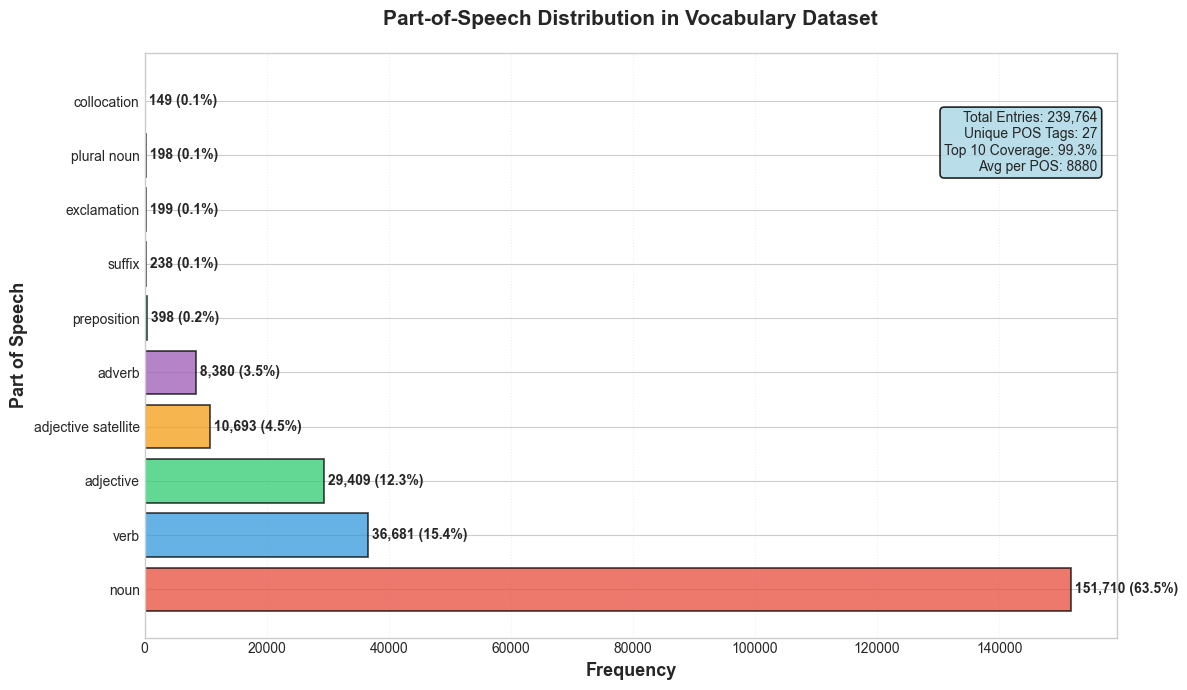


SECTION 6: WORD SENSE (POLYSEMY) ANALYSIS

Word Sense Distribution:
  Monosemous (1)            : 53,800 (57.5%)
  Low Polysemy (2-3)        : 24,116 (25.8%)
  Medium Polysemy (4-6)     :  9,494 (10.1%)
  High Polysemy (7+)        :  6,224 (6.6%)

Top 10 Most Polysemous Words:
  set                  : 145 senses
  call                 : 143 senses
  break                : 118 senses
  run                  : 115 senses
  down                 : 113 senses
  fall                 : 113 senses
  service              : 106 senses
  time                 : 105 senses
  cut                  : 104 senses
  post                 :  98 senses

✓ Saved: polysemy_distribution_vocab_data.png


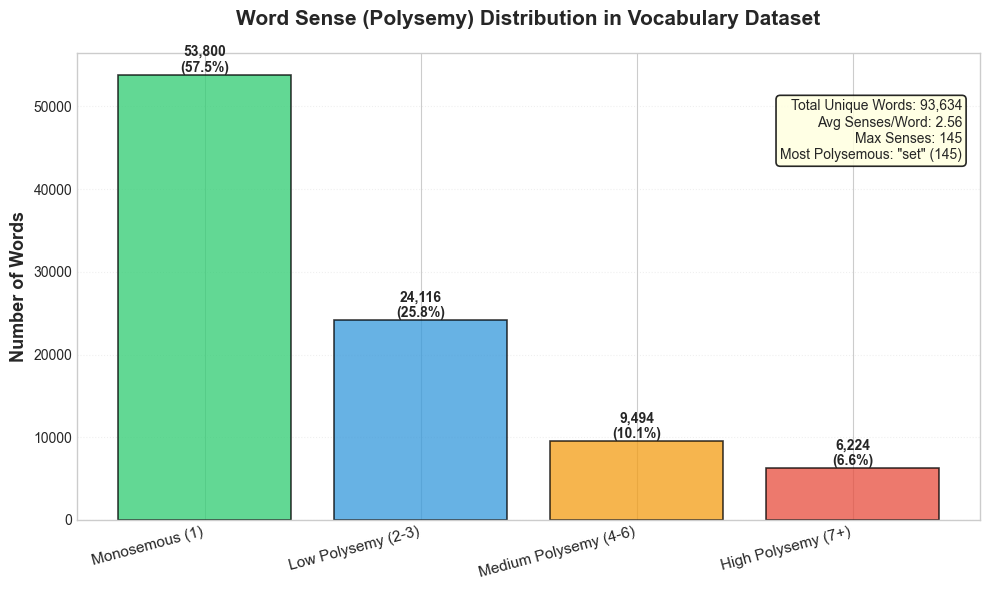


Vocabulary Data Analysis Complete


In [26]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import json
from collections import Counter

# Set publication-quality style
plt.style.use('seaborn-v0_8-whitegrid')
sns.set_palette("Set2")

# Load vocab data
with open('vocab_data.json', 'r', encoding='utf-8') as f:
    vocab_data = json.load(f)

print("\n" + "="*70)
print("SECTION 5: POS TAG DISTRIBUTION FROM VOCABULARY DATA")
print("="*70)

# POS tag mapping (abbreviation to full name)
pos_mapping = {
    'n': 'noun',
    'v': 'verb',
    'a': 'adjective',
    'r': 'adverb',
    's': 'adjective satellite',  # WordNet's adjective satellite
    'noun': 'noun',
    'verb': 'verb',
    'adjective': 'adjective',
    'adverb': 'adverb',
    'preposition': 'preposition',
    'suffix': 'suffix',
    'prefix': 'prefix',
    'exclamation': 'exclamation',
    'plural noun': 'plural noun',
    'collocation': 'collocation'
}

# Extract POS distribution from vocab_data.json with normalization
pos_counts = Counter()
for entry in vocab_data:
    pos = entry.get('pos', 'unknown')
    if pos and pos != 'unknown':
        # Normalize POS tags using mapping
        normalized_pos = pos_mapping.get(pos.lower(), pos)
        pos_counts[normalized_pos] += 1

print("\nPOS Tag Distribution (Normalized):")
for pos, count in pos_counts.most_common(15):
    print(f"  {pos:20s} : {count:7,} ({count/len(vocab_data)*100:.2f}%)")

# ========================================
# Academic-Quality POS Distribution Figure
# ========================================
fig, ax = plt.subplots(figsize=(12, 7))

# Get top 10 POS tags
top_pos = pos_counts.most_common(10)
pos_names = [pos for pos, _ in top_pos]
pos_values = [count for _, count in top_pos]

# Color palette
colors = ['#e74c3c', '#3498db', '#2ecc71', '#f39c12', '#9b59b6', 
          '#1abc9c', '#e67e22', '#95a5a6', '#34495e', '#16a085']

# Create horizontal bar chart
bars = ax.barh(pos_names, pos_values, color=colors, alpha=0.75, edgecolor='black', linewidth=1.2)

# Styling
ax.set_xlabel('Frequency', fontsize=13, fontweight='bold')
ax.set_ylabel('Part of Speech', fontsize=13, fontweight='bold')
ax.set_title('Part-of-Speech Distribution in Vocabulary Dataset', 
             fontsize=15, fontweight='bold', pad=20)
ax.grid(axis='x', alpha=0.3, linestyle=':', linewidth=0.8)

# Add value labels
for i, (pos, count) in enumerate(top_pos):
    percentage = (count / sum(pos_counts.values())) * 100
    ax.text(count, i, f' {count:,} ({percentage:.1f}%)', 
            va='center', fontsize=10, fontweight='bold')

# Add statistics box
stats_text = (
    f'Total Entries: {len(vocab_data):,}\n'
    f'Unique POS Tags: {len(pos_counts)}\n'
    f'Top 10 Coverage: {sum(pos_values)/len(vocab_data)*100:.1f}%\n'
    f'Avg per POS: {len(vocab_data)/len(pos_counts):.0f}'
)

ax.text(0.98, 0.90, stats_text, transform=ax.transAxes,
        fontsize=10, verticalalignment='top', horizontalalignment='right',
        bbox=dict(boxstyle='round', facecolor='lightblue', alpha=0.85, 
                  edgecolor='black', linewidth=1.2))

plt.tight_layout()
plt.savefig('pos_distribution_vocab_data.png', dpi=300, bbox_inches='tight')
print("\n✓ Saved: pos_distribution_vocab_data.png")
plt.show()

# ========================================
# SECTION 6: WORD SENSE ANALYSIS
# ========================================
print("\n" + "="*70)
print("SECTION 6: WORD SENSE (POLYSEMY) ANALYSIS")
print("="*70)

# Count how many definitions each word has
word_sense_count = Counter()
for entry in vocab_data:
    word = entry.get('word', '').lower()
    if word:
        word_sense_count[word] += 1

# Categorize by sense count
sense_distribution = {
    'Monosemous (1)': 0,
    'Low Polysemy (2-3)': 0,
    'Medium Polysemy (4-6)': 0,
    'High Polysemy (7+)': 0
}

for word, count in word_sense_count.items():
    if count == 1:
        sense_distribution['Monosemous (1)'] += 1
    elif count <= 3:
        sense_distribution['Low Polysemy (2-3)'] += 1
    elif count <= 6:
        sense_distribution['Medium Polysemy (4-6)'] += 1
    else:
        sense_distribution['High Polysemy (7+)'] += 1

print("\nWord Sense Distribution:")
for category, count in sense_distribution.items():
    percentage = (count / len(word_sense_count)) * 100
    print(f"  {category:25s} : {count:6,} ({percentage:.1f}%)")

# Find most polysemous words
top_polysemous = word_sense_count.most_common(10)
print("\nTop 10 Most Polysemous Words:")
for word, count in top_polysemous:
    print(f"  {word:20s} : {count:3} senses")

# ========================================
# Academic-Quality Polysemy Figure
# ========================================
fig, ax = plt.subplots(figsize=(10, 6))

categories = list(sense_distribution.keys())
values = list(sense_distribution.values())

colors_poly = ['#2ecc71', '#3498db', '#f39c12', '#e74c3c']

bars = ax.bar(range(len(categories)), values, 
              color=colors_poly, alpha=0.75, edgecolor='black', linewidth=1.2)

# Styling
ax.set_xticks(range(len(categories)))
ax.set_xticklabels(categories, rotation=15, ha='right', fontsize=11)
ax.set_ylabel('Number of Words', fontsize=13, fontweight='bold')
ax.set_title('Word Sense (Polysemy) Distribution in Vocabulary Dataset', 
             fontsize=15, fontweight='bold', pad=20)
ax.grid(axis='y', alpha=0.3, linestyle=':', linewidth=0.8)

# Add value labels
for i, (cat, val) in enumerate(zip(categories, values)):
    percentage = (val / sum(values)) * 100
    ax.text(i, val, f'{val:,}\n({percentage:.1f}%)', 
            ha='center', va='bottom', fontsize=10, fontweight='bold')

# Add statistics box
sense_counts_list = list(word_sense_count.values())
stats_text = (
    f'Total Unique Words: {len(word_sense_count):,}\n'
    f'Avg Senses/Word: {sum(sense_counts_list)/len(sense_counts_list):.2f}\n'
    f'Max Senses: {max(sense_counts_list)}\n'
    f'Most Polysemous: "{top_polysemous[0][0]}" ({top_polysemous[0][1]})'
)

ax.text(0.98, 0.90, stats_text, transform=ax.transAxes,
        fontsize=10, verticalalignment='top', horizontalalignment='right',
        bbox=dict(boxstyle='round', facecolor='lightyellow', alpha=0.85, 
                  edgecolor='black', linewidth=1.2))

plt.tight_layout()
plt.savefig('polysemy_distribution_vocab_data.png', dpi=300, bbox_inches='tight')
print("\n✓ Saved: polysemy_distribution_vocab_data.png")
plt.show()

print("\n" + "="*70)
print("Vocabulary Data Analysis Complete")
print("="*70)